In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"

In [2]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'lighthouse.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'lighthouse.png'),0)

tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'lighthouse_tri.png'),0)

print(img3.shape)
print(tri3.shape)

(480, 320, 3)
(480, 320)


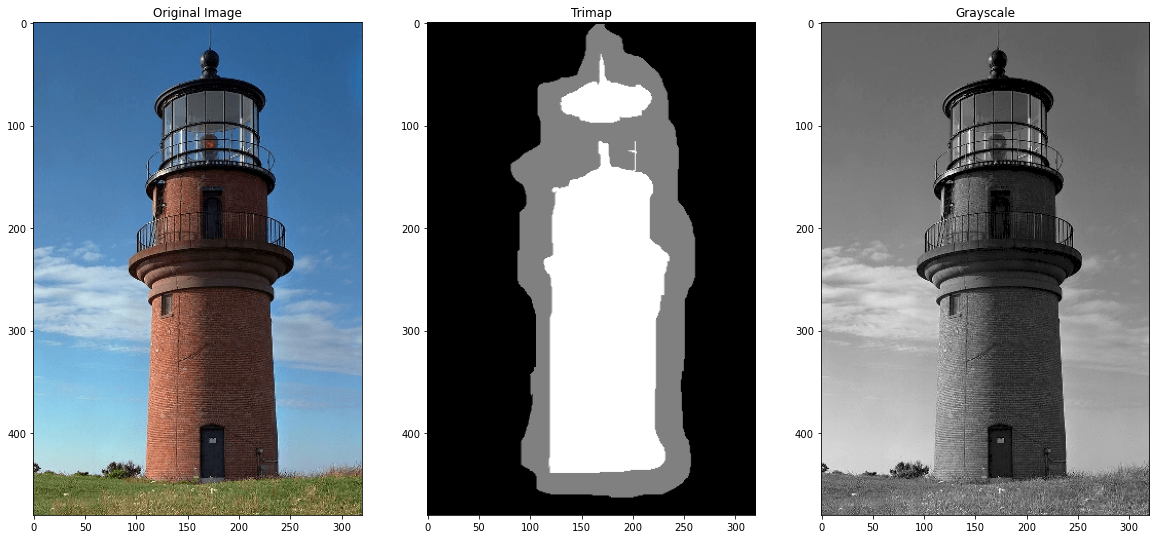

In [3]:
plt.figure(figsize = (20,15))

plt.subplot(131)
plt.imshow(img3)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(tri3,cmap='gray')
plt.title('Trimap')
plt.subplot(133)
plt.imshow(img3_gray,cmap='gray')
plt.title('Grayscale')


plt.show()

(480, 320, 3)


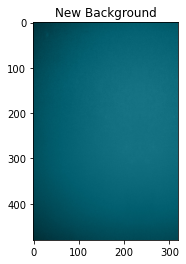

In [4]:
new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg2.jpg'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = cv2.resize(new_bg3, (img3.shape[1],img3.shape[0])) 
print(new_bg3.shape)
plt.imshow(new_bg3)
plt.title('New Background')
plt.show()

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



In [5]:
mask_bg = (tri3<10)
mask_fg = (tri3>245)
mask_unknown = (np.bitwise_and(tri3>=10,tri3<=245))

fg = img3_gray*(mask_fg)
bg = img3_gray*(mask_bg)
unknown = img3_gray*mask_unknown

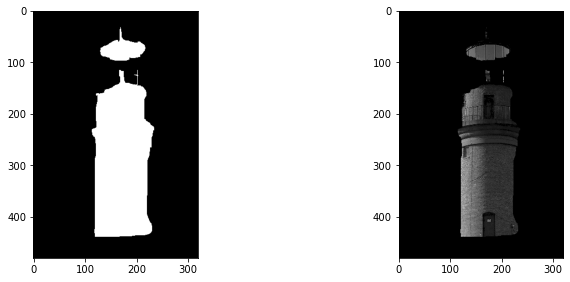

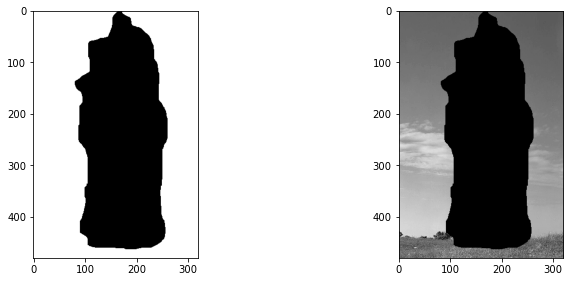

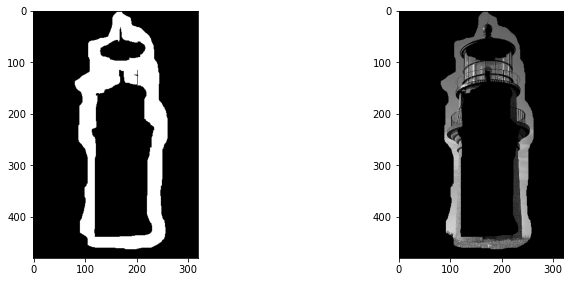

In [6]:
plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_fg,cmap='gray')
plt.subplot(222)
plt.imshow(fg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_bg,cmap='gray')
plt.subplot(222)
plt.imshow(bg,cmap='gray')
plt.show()

plt.figure(figsize = (12,10))
plt.subplot(221)
plt.imshow(mask_unknown,cmap='gray')
plt.subplot(222)
plt.imshow(unknown,cmap='gray')
plt.show()

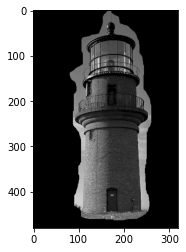

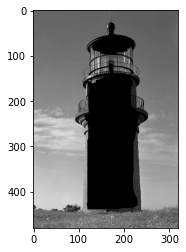

In [7]:
F = img3_gray*(mask_fg+mask_unknown)
B = img3_gray*(mask_bg+mask_unknown)

diff = np.minimum(np.maximum(F-B,0),255)

diff = ndimage.filters.gaussian_filter(diff, 0.9)
diff = np.minimum(np.maximum(diff,0),255)

plt.imshow(F,cmap='gray')
plt.show()
plt.imshow(B,cmap='gray')
plt.show()
# IF possible add a personal Gaussian filter in the next line
# diff = cv2.GaussianBlur(diff,(5,5),cv2.BORDER_DEFAULT)

In [8]:
grad_y,grad_x = np.gradient(img3_gray)
diff[diff==0] = 1
d2y_alpha, _ = np.gradient(grad_y/diff)
_, d2x_alpha = np.gradient(grad_x/diff)

In [9]:
d2alpha = d2y_alpha + d2x_alpha

In [10]:
estimate_alpha = mask_fg + 0.5*mask_unknown

In [19]:
def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 75, threshold = 0.2, beta = 1.5):
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
                        
    return alpha

In [26]:
alpha = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters=150, threshold = 2, beta = 3.0)
alpha = np.minimum(np.maximum(alpha,0),1)

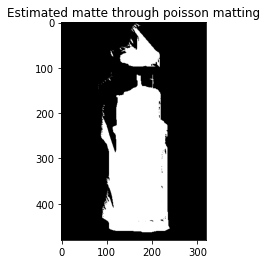

In [27]:
plt.imshow(alpha,cmap='gray')
plt.title('Estimated matte through poisson matting')
plt.show()

As we see local matting is not able to do well in some cases

# Alpha blending

### I = α F + (1 − α )B

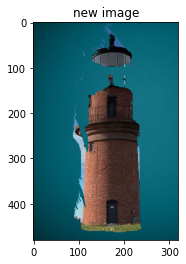

In [28]:

new_img = np.zeros(new_bg3.shape)
new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.title('new image')
plt.show()

##  Computationally efficient version of Global alpha matting

In [15]:
def optimal_alpha_matting(alpha, d2alpha, unknown):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(alpha.shape)
    h, w = img3_gray.shape
    threshold = 0.001
    iters = 50
    non_zero = np.nonzero(unknown)
    c_alpha = np.transpose(non_zero)
    c = c_alpha[(c_alpha[:,0]>=1)&(c_alpha[:,0]<h-1)&(c_alpha[:,1]>=1)&(c_alpha[:,1]<w-1)]
    first = c[:,0]
    second = c[:,1]
    diff = np.sum(np.abs(new_alpha - old_alpha))
    for i in range(iters):
        old_alpha = new_alpha.copy()
        new_alpha[first,second] = new_alpha[first-1 ,second]
        new_alpha[first,second] = new_alpha[first,second] 
        new_alpha[first,second] += new_alpha[first,second-1]
        new_alpha[first,second] += old_alpha[first, second+1] 
        new_alpha[first,second] += old_alpha[first+1,second]
        new_alpha[first,second] -= d2alpha[first,second]
        new_alpha[first,second] *= 1/4
        diff = np.sum(np.abs(new_alpha - old_alpha))
        if(diff < threshold):
            break
    return new_alpha

In [16]:
# print('Time for initial "Global Alpha Matting": ')
# %timeit global_alpha_matting(alpha, d2alpha, mask_unknown)
# print('Time for the new Optimal function: ')
# %timeit optimal_alpha_matting(alpha, d2alpha, mask_unknown)

Time for initial "Global Alpha Matting": 
23.8 s ± 1.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time for the new Optimal function: 
216 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


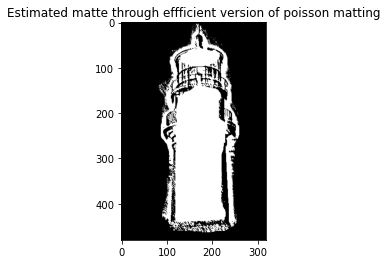

In [17]:
alpha = optimal_alpha_matting(alpha, d2alpha, mask_unknown)
alpha = np.minimum(np.maximum(alpha,0),1)

plt.imshow(alpha,cmap='gray')
plt.title('Estimated matte through effficient version of poisson matting')
plt.show()

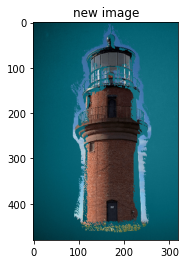

In [18]:
# alpha blending
new_img = np.zeros(new_bg3.shape)
new_img[:,:,0] = alpha*img3[:,:,0] + (1-alpha)*new_bg3[:,:,0]
new_img[:,:,1] = alpha*img3[:,:,1] + (1-alpha)*new_bg3[:,:,1]
new_img[:,:,2] = alpha*img3[:,:,2] + (1-alpha)*new_bg3[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.title('new image')
plt.show()